# Исследование надёжности заёмщиков

Заказчик проекта — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Цель исследования – ответить на вопросы:
 1. Есть ли зависимость между наличием детей и возвратом кредита в срок?
 2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
 3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
 4. Как разные цели кредита влияют на его возврат в срок?

### Ход исследования:
 1. Обзор данных:
 2. Предобработка данных.
 3. Ответы на вопросы.


 ### Описание данных:

- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита



### Подготовка окружения
Удобно загрузить все библиотеки, требуемые для работы в ходе проекта в рамках одной ячейки.

In [1]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

---

## Шаг 1. Открытие файла с данными и изучение информации о данных

Для безопасного открытия файла как при локальной работе, так и при работе в виртуальном окружении, используем связку try-except – средство обработки исключений.

In [2]:
try:
    client_stats = pd.read_csv('/datasets/data.csv')
except FileNotFoundError:
    client_stats = pd.read_csv('-') # Прямая ссылка на датасет удалена в связи с правилами публикации проектов

Изучим полученные от банка данные, отобразив датасет.

In [3]:
client_stats

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


По результатам изучения пяти первых и пяти последних строк датасета можно сделать следующие выводы
- сразу бросается в глаза **специфическая аномалия в датасете**, такая как **отрицательные значения** в столбце `days_employed`. На первый взгляд складывается ощущение зависимости между появлением отрицательных значений и данными столбце `income_type`: отрицательные значения соответствуют всем типам занятости, кроме типа "пенсионер". Кроме этого, стаж пенсионеров кратно больше стажа всех прочих категорий. Следует пристальнее изучить причину появления таких значений и исправить значения на корректные;
- также обращает внимание на себя **не унифицированный стиль хранения данных** в датасете: в столбце `education` среднее образование указано в разными значениями – "среднее" и "Среднее"; а также в столбце `purpose` одна и та же цель указана в различных формулировках – "приобретение автомобиля", "сделка с автомобилем", "на покупку своего автомобиля", "на покупку автомобиля". Эта проблема может привести как к дублированию данных в датасете, так и к усложненнию анализа, что приведет к искажению его результатов;
- **данные категориального типа хранятся в строковом виде**, типом "object", количественные данные хранятся в соответствующих типах, так что в изменении типов данных нет необходимости.

Также отобразим информацию о самом датасете и структуре данных в нем. Используем аргумент memory_usage для получения точного значения используемой памяти.

In [4]:
client_stats.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 11.3 MB


Для изучения датасета в R есть удобный инструмент str(), которого, к сожалению нет в pandas. Для исправления этого досадного упущения напишем функцию, частично замещающую этот функционал. Она поможет обнаружить дополнительные аномалии.

In [5]:
def unique_values(df):
    return df.apply(lambda x: [x.unique()])

pd.options.display.max_colwidth = 100
pd.DataFrame(unique_values(client_stats))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,"[1, 0, 3, 2, -1, 4, 20, 5]","[-8437.673027760233, -4024.803753850451, -5623.422610230956, -4124.747206540018, 340266.07204682...","[42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24, 21, 57, 67, 28, 63, 62, 47,...","[высшее, среднее, Среднее, СРЕДНЕЕ, ВЫСШЕЕ, неоконченное высшее, начальное, Высшее, НЕОКОНЧЕННОЕ...","[0, 1, 2, 3, 4]","[женат / замужем, гражданский брак, вдовец / вдова, в разводе, Не женат / не замужем]","[0, 1, 2, 3, 4]","[F, M, XNA]","[сотрудник, пенсионер, компаньон, госслужащий, безработный, предприниматель, студент, в декрете]","[0, 1]","[253875.6394525987, 112080.01410244204, 145885.95229686378, 267628.5503294142, 158616.0778700629...","[покупка жилья, приобретение автомобиля, дополнительное образование, сыграть свадьбу, операции с..."


Также нелишним будет взглянуть на статистическую характеристику датасета.

In [6]:
client_stats.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Более глубокое изучение датасета дает нам дополнительную информацию о аномалиях, встречающихся в данных:
- **в данных встречаются пропуски**: очевидные в столбцах `days_employed`, `total_income`, в них не хватает значений и в столбце `gender`, в котором пропущенные значения отмечены как "XNA". Также в столбце `dob_years` есть нулевые значения, что невозможно. Так как в столбцах с количественными переменными указаны числовые тип столбца, строковые значения "None" в них отсутствуют. Вероятнее всего пропуски в столбцах `days_employed`, `dob_years` и `total_income` вызваны нежеланием клиента разглашать эту информацию или ошибкой ссотрудника, вносившего данные. Пропуск в столбце `gender` может быть вызван ошибкой сотрудника банка, вносившего данные;
- **в столбце `children` есть отрицательные значения**, которые также необходимо изучить;
- в силу незначительного объема датасета и занимаемой им памяти, **оптимизировать представление данных в нем необязательно, но возможно**, например изменить типы данных в столбцах или вынести категориальные переменные в отдельный датафрейм-словарь.

**Вывод**

Полученная информация в результате изучения датасета позволила сделать следующие выводы:
- в датасете есть аномалии – отрицательные значения в столбцах с данными, не предполагающими отрицательные значения. Это столбцы:
    - `children`;
    - `days_employed`;
- данные указаны по-разному в столбцах:
    - `education`;
    - `purpose`;
- в датасете встречаются пропуски в столбцах:
    - `days_employed`;
    - `total_income`;
    - `gender`;
    - `dob_years`;
- тип хранения данных не оптимальный.

---

## Шаг 2. Предобработка данных

На основании выводов, сделанных в ходе изучения данных, можно составить последовательность предобработки данных:
1. **Изучение и исправление аномалий в столбцах `children` и `days_employed`.**
2. **Унификация значений в столбцах:**
    - `education` – проще всего заменить различающиеся значения в столбце на значения в нижнем регистре;
    - `purpose` – для унификации значений в этом столбце следует провести лемматизацию и привести цели к общему виду;
3. **Обработка пропусков в столбцах:**
    - `dob_years` - пропущенные значения заменим на средний возраст;
    - `days_employed` – замена пропусков на среднее значение для конкретного возраста. Среднее значение берется так как возраст принимает значение в ограниченном диапазоне, выбросы невозможны. Так как стаж сотрудника вероятно имеет наиболее сильную корреляцию с возрастом, брать среднее значение целесообразно именно по возрасту;
    - `total_income` – замена пропусков на медиану по уровню образования. Медиана берется исходя из неограниченности диапазона значений дохода, в котором возможны значительные выбросы. Уровень образования напрямую влияет на размер дохода, поэтому медиана берется в зависимости от него;
    - `gender` – пропущенные значения столбца следует изучить отдельно, так как прямой зависимости пропусков с другими столбцами пока не обнаружено и неизвестно количество пропущенных значений;
4. **Замена типа данныых.**
5. **Обработка дубликатов.**
6. **Категоризация данных.**

### Исправление аномалий в данных

Для изучения отрицательных значений в столбце `children` выведем на экран количество всех строк, где число детей отрицательно.

In [7]:
negative_children_count = client_stats[client_stats['children'] < 0]['children'].count()

print(f'Количество строк, с отрицательными значениями в столбце "children" равняется {negative_children_count}.')

Количество строк, с отрицательными значениями в столбце "children" равняется 47.


Это 0,2% от всего датасета, даже если эта ошибка является неслучайной, можно свободно изменить отрицательные значения на положительные, такое изменение практически не исказит итоговые результаты анализа. Возьмем модуль значений столбца `children`.

In [8]:
client_stats['children'] = client_stats['children'].abs()

Проверим, все ли строки, содержавшие отрицательные значения были заменены.

In [9]:
negative_children_count = client_stats[client_stats['children'] < 0]['children'].count()

print(f'Количество строк, с отрицательными значениями в столбце "children" равняется {negative_children_count}.')

Количество строк, с отрицательными значениями в столбце "children" равняется 0.


Для изучения отрицательных значений в столбце `days_employed` выведем описательную структуру столбца, сгруппированного по значению `income_type`.

In [10]:
client_stats.groupby(by='income_type')['days_employed'].describe()

,count,mean,std,min,25%,50%,75%,max
income_type,,,,,,,,
безработный,2.0,366413.652744,40855.478519,337524.466835,351969.059790,366413.652744,380858.245699,395302.838654
в декрете,1.0,-3296.759962,NaN,-3296.759962,-3296.759962,-3296.759962,-3296.759962,-3296.759962
госслужащий,1312.0,-3399.896902,2788.371363,-15193.032201,-4759.399260,-2689.368353,-1257.171811,-39.954170
компаньон,4577.0,-2111.524398,2048.448594,-17615.563266,-2876.648520,-1547.382223,-685.687432,-30.195337
пенсионер,3443.0,365003.491245,21069.606065,328728.720605,346649.346146,365213.306266,383231.396871,401755.400475
предприниматель,1.0,-520.848083,NaN,-520.848083,-520.848083,-520.848083,-520.848083,-520.848083
сотрудник,10014.0,-2326.499216,2307.924129,-18388.949901,-3108.123025,-1574.202821,-746.027361,-24.141633
студент,1.0,-578.751554,NaN,-578.751554,-578.751554,-578.751554,-578.751554,-578.751554


Так как в столбце `days_employed` указан общий трудовой стаж в днях, значения, содержащиеся в датасете выглядят очень необычно. Так, согласно данным, полученным от банка, стаж среднего пенсионера составляет 365 003 дня. При среднем количестве рабочих дней в году в размере 247 дней, средний пенсионер за свою жизнь отработал 365 003 / 247 ~ 1 478 лет! Либо это потрясающая работоспособность и маховик времени, либо в столбце с трудовым стажем категории "пенсионер" и "безработный" содержат ошибки. 

Можно предположить, что данные в датасете указаны с ошибкой в количестве знаков перед запятой, то есть в 10 или 100 раз больше. Но тогда среднее значение стажа для пенсионера составит 3 650 / 247 ~ 14,78 лет, а максимальное 4 018 / 247 ~ 16,27 лет. Это совершенно нереалистичные цифры, если только клиенты банка не сотрудники МВД и вооруженных сил.
В категориях "сотрудник", "госслужащий" и "компаньон" также есть достаточно высокие показатели, 

Согласно данным [ria.ru](https://ria.ru/20131119/977986173.html), средний стаж в России до выхода на пенсию составляет 34,5 года. При среднем количестве рабочих дней, средний стаж пенсионера должен составлять 247 * 34,5 ~ 8 521 день. Указанные в таблице данные даже близко не сравнимы со средним стажем, поэтому единственный вариант получить достоверные данные – уточнить у коллег, которые предоставили информацию.

Выясним, на какой коэффициент вероятно умножены значения стажа пенсионеров и безработных. Возьмем среднее значение для них и поделим на более реалистичный средний стаж. 365 003 / 8521 ~  42,84.
Рассчитаем более актуальный стаж.

In [11]:
client_stats.loc[client_stats['income_type']=='безработный', 'days_employed'] = client_stats.loc[client_stats['income_type']=='безработный', 'days_employed'].div(42,84)
client_stats.loc[client_stats['income_type']=='пенсионер', 'days_employed'] = client_stats.loc[client_stats['income_type']=='пенсионер', 'days_employed'].div(42,84)

При этом отрицательные значения вероятно просто техническая ошибка при выгрузке базы данных или трансоформации данных. Поэтому эти значения возьмем по модулю.

In [12]:
client_stats['days_employed'] = client_stats['days_employed'].abs()
client_stats

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,8101.573144,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,8188.985813,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


**Вывод**

Данные столбца `children` были взяты по модулю в силу незначительности количества аномалий.

Столбец `days_employed` был полностью изменен таким образом, что бы соответствовать более реальным значениям.

### Унификация значений в столбцах заменой и лемматизацией

Для начала заменим значения в столбце `education` на значения в нижнем регистре и проверим, остались ли различающиеся значения одного и того же уровня образования.

In [13]:
client_stats['education'] = client_stats['education'].str.lower()
client_stats['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

После изменения все различающиеся значения пришли к единообразному виду.

Для унификации значений в столбце `purpose` проведем лемматизацию. Для этого нам понадобится объект "Mystem" из библиотеки "pymystem3".

In [14]:
m = Mystem()

Сперва изучим список уникальных целей в столбце `purpose`.

In [15]:
print(client_stats['purpose'].unique())

['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего жилья'
 'операции с недвижимостью' 'получение высшего образования'
 'свой автомобиль' 'сделка с автомобилем' 'профильное образование'
 'высшее образование' 'покупка жилья для сдачи' 'на покупку автомобиля'
 'ремонт жилью' 'заняться высшим образованием']


Посчитаем частоту с которой те или иные слова встречаются в целях кредита

In [16]:
lemmas = []
for aim in client_stats['purpose'].unique():
    for word in aim.split(' '):
        lemmas.extend(m.lemmatize(word))
Counter(lemmas)

Counter({'покупка': 10,
         '\n': 97,
         'жилье': 7,
         'приобретение': 1,
         'автомобиль': 9,
         'дополнительный': 2,
         'образование': 9,
         'сыграть': 1,
         'свадьба': 3,
         'операция': 4,
         'с': 5,
         'на': 4,
         'проведение': 1,
         'для': 2,
         'семья': 1,
         'недвижимость': 10,
         'коммерческий': 2,
         'жилой': 2,
         'строительство': 3,
         'собственный': 1,
         'подержать': 2,
         'свой': 4,
         'со': 1,
         'заниматься': 2,
         'сделка': 2,
         'получение': 3,
         'высокий': 3,
         'профильный': 1,
         'сдача': 1,
         'ремонт': 1})

Из списков видно, что основные цели кредита – покупка и ремонт недвижимости, автомобиля, получение образования и свадьба. Различаются только детали и формулировка цели. Так как для целью исследования не является выяснить различия в вероятности возврата кредита в срок для немного различающихся целей, таких как приобретение недвижимости в личное пользование и в аренду, сразу категоризируем цели кредита, приведя их к четырем единообразным категориям.
Составим список унифицированных целей в виде словаря, в котором лемматизированные слова сответствуют цели.

In [17]:
unique_aims = {
    'недвижимость': 'приобретение и ремонт недвижимости',
    'жилье': 'приобретение и ремонт недвижимости',
    'жилой': 'приобретение и ремонт недвижимости',
    'автомобиль': 'приобретение автомобиля',
    'свадьба': 'свадьба', 
    'образование': 'получение образования'
}

Напишем функцию, которая получая на вход значение цели, возвращает унифицированную цель.

In [18]:
def unify_aims(aim):
    for key, value in unique_aims.items():
        if key in m.lemmatize(aim):
            return value

Применим функцию к столбцу `purpose` датасета и убедимся, что функция распознала все цели и в столбце не осталось пустых значений или неунифицированно написанных значений.

In [19]:
client_stats['purpose'] = client_stats['purpose'].apply(unify_aims)
client_stats['purpose'].unique()

array(['приобретение и ремонт недвижимости', 'приобретение автомобиля',
       'получение образования', 'свадьба'], dtype=object)

**Вывод**

После обработки в столбцах `education` и `purpose` не осталось разнящихся значений, все значения приведены к единому виду и можно с ними работать.

### Обработка пропусков

Для изучения отрицательных значений в столбце `dob_years` выведем описательную структуру столбца, сгруппированного по значению `income_type`.

In [20]:
client_stats.groupby(by='income_type')['dob_years'].describe()

,count,mean,std,min,25%,50%,75%,max
income_type,,,,,,,,
безработный,2.0,38.000000,9.899495,31.0,34.50,38.0,41.50,45.0
в декрете,1.0,39.000000,NaN,39.0,39.00,39.0,39.00,39.0
госслужащий,1459.0,40.636737,10.744491,0.0,32.00,40.0,48.00,75.0
компаньон,5085.0,39.697542,10.671115,0.0,31.00,39.0,48.00,74.0
пенсионер,3856.0,59.063019,7.618526,0.0,56.00,60.0,64.00,74.0
предприниматель,2.0,42.500000,21.920310,27.0,34.75,42.5,50.25,58.0
сотрудник,11119.0,39.821027,10.655127,0.0,32.00,39.0,48.00,74.0
студент,1.0,22.000000,NaN,22.0,22.00,22.0,22.00,22.0


В столбце есть значения, равные нулю, что невозможно, так как кредиты не выдают младенцам, поэтому, исходя из ограиченности ряда данных возраста и отсутствия в данных выбросов, заполним пропуски в столбце `dob_years` средним значением возраста. Найдем среднее значение возраста.

In [21]:
mean_age = int(client_stats.dob_years.mean())

Заменим пропущенные значения в столбце `dob_years` на среднее значение.

In [22]:
client_stats['dob_years'] = client_stats['dob_years'].replace(0, mean_age)

Проверим, остались ли нулевые значения в столбце.

In [23]:
client_stats['dob_years'].describe()

count    21525.000000
mean        43.495145
std         12.218213
min         19.000000
25%         34.000000
50%         43.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

In [24]:
client_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Минимальное значение возраста сменилось на 19 лет, значит нулевые значения отсутствуют. Среднее значение возраста несколько изменилось, однако незначительно.

Для столбца `total_income` необходимо заменить пропуски на медиану по уровню образования. Для этого составим словарь соответствия уровня образования среднему доходу.

In [25]:
income_by_education = client_stats.groupby(by='education')['total_income'].describe()['50%'].to_dict()

Заменим пропущенные значения в столбце `total_income` на медианные значения по образованию.

In [26]:
client_stats['total_income'] = client_stats['total_income'].fillna(client_stats['education'].map(income_by_education))

Проверим, остались ли пропущенные значения в столбце.

In [27]:
client_stats['total_income'].isna().sum()

0

Для столбца `days_employed` необходимо заменить пропуски на среднее по возрасту. Для этого составим словарь соответствия возраста стажу.

In [28]:
days_employed_by_age = client_stats.groupby(by='dob_years')['days_employed'].describe()['mean'].to_dict()

Заменим пропущенные значения в столбце `days_employed` на средние значения по возрасту.

In [29]:
client_stats['days_employed'] = client_stats['days_employed'].fillna(client_stats['dob_years'].map(days_employed_by_age))


Проверим, остались ли пропущенные значения в столбце.

In [30]:
client_stats['days_employed'].isna().sum()

0

Изучим пропущенные значения в столбце `gender`.

In [31]:
client_stats[client_stats['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,приобретение и ремонт недвижимости


Так как пропущенное значение в столбце всего одно, его можно отбросить, так как в массиве из 21 тысячи значений оно не повлияет на результат.

In [32]:
client_stats = client_stats[client_stats['gender'] != 'XNA']

Проверим, остались ли в датасете пропущенные значения.

In [33]:
client_stats.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21524 non-null  int64  
 1   days_employed     21524 non-null  float64
 2   dob_years         21524 non-null  int64  
 3   education         21524 non-null  object 
 4   education_id      21524 non-null  int64  
 5   family_status     21524 non-null  object 
 6   family_status_id  21524 non-null  int64  
 7   gender            21524 non-null  object 
 8   income_type       21524 non-null  object 
 9   debt              21524 non-null  int64  
 10  total_income      21524 non-null  float64
 11  purpose           21524 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 14.0 MB


**Вывод**

В результате обработки пропусков неизвестные значения дохода, стажа и возраста были заменены на медиану по образованию, среднее значение стьажа и среднее значение по возрасту, а неизвестное значение пола было отброшено.

### Обработка дубликатов

Проверим, все ли принимаемые категориальные значения уникальны, что бы избежать наличия в таблице неявных дубликатов.

In [34]:
pd.options.display.max_colwidth = 100
pd.DataFrame(unique_values(client_stats))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,"[1, 0, 3, 2, 4, 20, 5]","[8437.673027760233, 4024.803753850451, 5623.422610230956, 4124.747206540018, 8101.573143971951, ...","[42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24, 21, 57, 67, 28, 63, 62, 47,...","[высшее, среднее, неоконченное высшее, начальное, ученая степень]","[0, 1, 2, 3, 4]","[женат / замужем, гражданский брак, вдовец / вдова, в разводе, Не женат / не замужем]","[0, 1, 2, 3, 4]","[F, M]","[сотрудник, пенсионер, компаньон, госслужащий, безработный, предприниматель, студент, в декрете]","[0, 1]","[253875.6394525987, 112080.01410244204, 145885.95229686378, 267628.5503294142, 158616.0778700629...","[приобретение и ремонт недвижимости, приобретение автомобиля, получение образования, свадьба]"


Все категориальные значения уникальны, не дублируются, поэтому для удаления дубликатов достаточно воспользоваться методом удаления явных дубликатов.

Посчитаем в таблице количество явных дубликатов.

In [35]:
client_stats.duplicated().sum()

408

Вероятно дубликаты в данных появились вледствии технической ошибки, либо ошибки при трансформации данных или выгрузке из базы.
Удалим дублирующиеся значения с помощью метода drop_duplicates.

In [36]:
client_stats = client_stats.drop_duplicates().reset_index(drop=True)

Снова посчитаем колличество дубликатов

In [37]:
client_stats.duplicated().sum()

0

**Вывод**

Все дублирующиеся значения удалены, они не исказят результаты исследования.

### Изменение типа данных

Заменим тип данных в столбцах `days_employed` и `total_income` с вещественного на целочисленный. В столбце `days_employed` ннеобходимо изменить тип данных так как стаж измеряется в днях, а день это целочисленная единица измерения. В столбце `total_income` информация о дробной части в ежемесячном доходе является несущественной для целей использования данных.

In [38]:
client_stats['days_employed'] = client_stats['days_employed'].astype('int')

In [39]:
client_stats['total_income'] = client_stats['total_income'].astype('int')

In [40]:
client_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21116 entries, 0 to 21115
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21116 non-null  int64 
 1   days_employed     21116 non-null  int64 
 2   dob_years         21116 non-null  int64 
 3   education         21116 non-null  object
 4   education_id      21116 non-null  int64 
 5   family_status     21116 non-null  object
 6   family_status_id  21116 non-null  int64 
 7   gender            21116 non-null  object
 8   income_type       21116 non-null  object
 9   debt              21116 non-null  int64 
 10  total_income      21116 non-null  int64 
 11  purpose           21116 non-null  object
dtypes: int64(7), object(5)
memory usage: 1.9+ MB


**Вывод**

Данные в столбцах заменены на целочисленный тип данных.

### Категоризация данных

Так как частично категоризация уже выполнена с помощью лемматизации и цели сгруппированы в несколько больших, критически различающихся категорий, осталось разделить данные еще по одному признаку, что бы получить достаточно характерные и различающиеся группы. Так как уровень дохода считается очень важным и репрезентативнм признаком, а также отражает в себе значения прочих признаков, таких как пол, тип занятости и возраст, выполним категоризацию по нему. Сперва выделим основные группы, по которым разделим данные на категории.

Удобно разделить уровень дохода на пять групп:
- низкий
- ниже среднего
- средний
- выше среднего
- высокий

За средний доход возьмем медиану, а шагом группы усеченное стандартное отклонение, таким образом мы получим более репрезентативные группы. Группы распределим таким образом, что бы медиана была медианным значением и в группе среднего дохода.

In [41]:
pd.set_option('float_format', '{:f}'.format)
print(client_stats['total_income'].describe(percentiles=[0.05, 0.95]))
client_stats[(client_stats['total_income'] > 64334.220480) &
             (client_stats['total_income'] < 332382.835791)]['total_income'].std()

count     21116.000000
mean     165802.986929
std       98852.504647
min       20667.000000
5%        64332.750000
50%      142321.000000
95%      332392.500000
max     2265604.000000
Name: total_income, dtype: float64


59370.68312515682

In [42]:
median = 153715.643971
std = 59640.22474141418
g_3 = median - std / 2
g_2 = g_3 - std
g_4 = g_3 + std
g_5 = g_4 + std
pd.DataFrame.from_dict({
    'group': ['низкий', 'ниже среднего', 'средний', 'выше среднего', 'высокий'],
    'min': [0, g_2, g_3, g_4, g_5],
    'max': [g_2, g_3, g_4, g_5, '-']
})

,group,min,max
0,низкий,0.000000,64255.306859
1,ниже среднего,64255.306859,123895.531600
2,средний,123895.531600,183535.756342
3,выше среднего,183535.756342,243175.981083
4,высокий,243175.981083,-


Таким образом примерно половина выборки попадает в группу среднего дохода и половина в прочие группы.

Напишем функцию, присваивающую категорию в соотсветствии с уровнем дохода и создадим столбец с категорией уровня дохода.

In [43]:
def grop_by_income_amount(row):
    income = row['total_income']
    if income <= 64255.306859:
        return 'низкий'
    elif income <= 123895.531600:
        return 'ниже среднего'
    elif income <= 183535.756342:
        return 'средний'
    elif income <= 243175.981083:
        return 'выше среднего'
    return 'высокий'

In [44]:
client_stats['income_group'] = client_stats.apply(grop_by_income_amount, axis=1)

Посмотрим, каким образом данные разделились на группы.

In [45]:
display(client_stats)
client_stats['income_group'].value_counts()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,приобретение и ремонт недвижимости,высокий
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,ниже среднего
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,приобретение и ремонт недвижимости,средний
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,получение образования,высокий
4,0,8101,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,свадьба,средний
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21111,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,приобретение и ремонт недвижимости,выше среднего
21112,0,8188,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,приобретение автомобиля,средний
21113,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,приобретение и ремонт недвижимости,ниже среднего
21114,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,приобретение автомобиля,высокий


средний          7666
ниже среднего    6224
выше среднего    3153
высокий          3026
низкий           1047
Name: income_group, dtype: int64

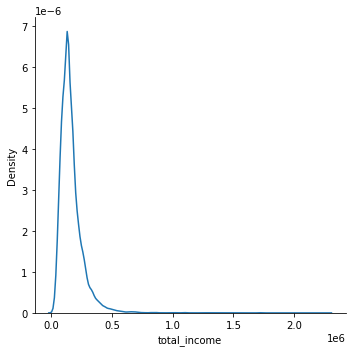

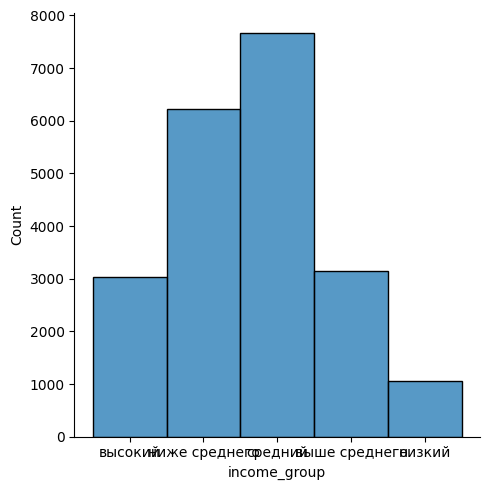

In [46]:
sns.displot(client_stats, x='total_income', kind="kde")
sns.displot(client_stats, x='income_group')

На графиках видно, что распределение по группам примерно соответствует действительному распределению дохода в выборке.

Также выделим данные столбцов `education` и `family_status` в отдельные словари, так мы избавимся от избыточной информации в датасете. Для этого разобъем датасет на словарь и данные раздельно.

In [47]:
client_stats_data = client_stats.drop(['education', 'family_status'], axis=1)
education_dict = client_stats.loc[:, ['education_id', 'education']].drop_duplicates().reset_index(drop=True)
family_status_dict = client_stats.loc[:, ['family_status_id', 'family_status']].drop_duplicates().reset_index(drop=True)

 **Вывод**

В результате категоризации через лемматизацию и категоризацию по уровню дохода и наличию детей мы получили 4 категории цели: 
- приобретение и ремонт недвижимости
- приобретение автомобиля
- получение образования
- свадьба

6 категорий уровня дохода:
- высокий
- ниже среднего
- средний
- выше среднего
- низкий

Также избыточные данные были вынесены в отдельные словари.

Теперь, после предобработки можно ответить на вопросы цели исследования.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для ответа на этот вопрос создадим сводную таблицу и вычислим процент должников среди тех, у кого есть ребенок и тех, у кого его нет.

In [48]:
percent_of_debtors_by_children = pd.pivot_table(client_stats_data, values='purpose', index='children', columns='debt', aggfunc='count')
percent_of_debtors_by_children['percent_of_debtors'] = percent_of_debtors_by_children[1] / percent_of_debtors_by_children[0] * 100
percent_of_debtors_by_children

debt,0,1,percent_of_debtors
children,,,
0,12765.000000,1061.000000,8.311790
1,4352.000000,445.000000,10.225184
2,1845.000000,194.000000,10.514905
3,302.000000,27.000000,8.940397
4,36.000000,4.000000,11.111111
5,9.000000,NaN,NaN
20,68.000000,8.000000,11.764706


Если некоторая зависимость между наличием детей и вероятностью погашения кредита в срок есть, то она незначительная, в пределах 2-3%.

**Вывод**

Зависимость между наличием детей и возвратом кредита в срок незначительная, но существует. Клиенты, не имеющие детей, вероятнее вернут кредит в срок, чем те, у кого они есть. Также есть разница между семьями с 3 детьми и другим количеством детей. Клиенты с тремя детьми вернут кредит вовремя практически с такой же вероятностью как и клиенты без детей, но вероятно это статистическое отклонение.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [49]:
percent_of_debtors_by_family_status = pd.pivot_table(client_stats_data, values='purpose', index='family_status_id', columns='debt', aggfunc='count')
percent_of_debtors_by_family_status.index = percent_of_debtors_by_family_status.index.to_series().map(family_status_dict.to_dict()['family_status'])
percent_of_debtors_by_family_status['percent_of_debtors'] = percent_of_debtors_by_family_status[1] / percent_of_debtors_by_family_status[0] * 100
percent_of_debtors_by_family_status

debt,0,1,percent_of_debtors
family_status_id,,,
женат / замужем,11145,929,8.335576
гражданский брак,3734,388,10.391002
вдовец / вдова,880,63,7.159091
в разводе,1108,85,7.671480
Не женат / не замужем,2510,274,10.916335


**Вывод**

У клиентов, не состовших в официальном браке вероятность вернуть кредит в срок незначительно ниже.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [50]:
percent_of_debtors_by_income_group = pd.pivot_table(client_stats_data, values='children', index='income_group', columns='debt', aggfunc='count')
percent_of_debtors_by_income_group['percent_of_debtors'] = percent_of_debtors_by_income_group[1] / percent_of_debtors_by_income_group[0] * 100
percent_of_debtors_by_income_group


debt,0,1,percent_of_debtors
income_group,,,
высокий,2819,207,7.343029
выше среднего,2899,254,8.761642
ниже среднего,5697,527,9.250483
низкий,978,69,7.055215
средний,6984,682,9.765178


**Вывод**

Наиболее низкая вероятность своевременного возврата кредита - у людей со средним доходом, наиболее вероятно, что человек с высокими и, как ни странно, низкими доходами вернет кредит своевременно.

- Как разные цели кредита влияют на его возврат в срок?

In [51]:
percent_of_debtors_by_purpose = pd.pivot_table(client_stats_data, values='gender', index='purpose', columns='debt', aggfunc='count')
percent_of_debtors_by_purpose['percent_of_debtors'] = percent_of_debtors_by_purpose[1] / percent_of_debtors_by_purpose[0] * 100
percent_of_debtors_by_purpose

debt,0,1,percent_of_debtors
purpose,,,
получение образования,3594,370,10.294936
приобретение автомобиля,3870,402,10.387597
приобретение и ремонт недвижимости,9793,781,7.975084
свадьба,2120,186,8.773585


**Вывод**

Люди, взявшие кредит на свадьбу или операции с недвижимостью, более вероятно вернут кредит свовременно, чем те, кто взял его на образование и приобретение автомобиля. Однако это отклонение также не слишком значительно.

## Шаг 4. Общий вывод

Такие факторы как официальный брак, наличие детей, уровень дохода и цель оформления кредита, не слишком значительно влияют на вероятность своевременного возвращения кредита. Также эти факторы достаточно тесно связаны с жизненным этапом человека, поэтому отклонения могут быть отражением влияния фактора возраста на вероятность возврата кредита.

<AxesSubplot:xlabel='dob_years', ylabel='percent_of_debtors'>

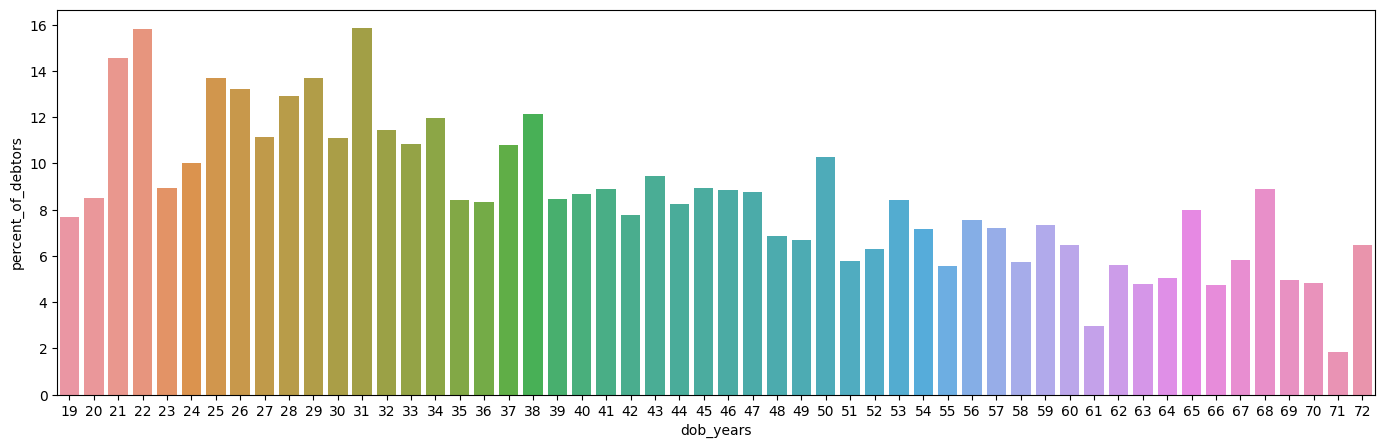

In [52]:
percent_of_debtors_by_purpose = pd.pivot_table(client_stats, values='purpose', index='dob_years', columns='debt', aggfunc='count')
percent_of_debtors_by_purpose['percent_of_debtors'] = percent_of_debtors_by_purpose[1] / percent_of_debtors_by_purpose[0] * 100
percent_of_debtors_by_purpose = percent_of_debtors_by_purpose.dropna()
percent_of_debtors_by_purpose = percent_of_debtors_by_purpose.reset_index()
plt.figure(figsize=(17,5))
sns.barplot(data=percent_of_debtors_by_purpose, x='dob_years', y='percent_of_debtors')

По графику можно однозначно сказать, что с возрастом, количество должников снижается, но с возрастом, люди менее вероятно станут покупать машину в кредит и брать кредит на образование, с возрастом у человека вероятнее будут дети, чем у более молодых людей и чем старше человек, тем вероятнее он будет состоять в официальном браке. Также уровень дохода растет по мере стажа и продвижения по карьерной лестнице, так что можно сделать вывод о том, что отклоненение в рассмотренных выше показателях, вызвано скорее влиянием возраста человека на возврат кредит в срок. И поэтому эти показатели сами по себе не имеют значительного влияния на вероятность возврата кредита.